In [1]:
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse
from plotnine import *
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import utils


In [2]:
chicago_df = utils.read_parquet('chicago_taxi_trips_15percent_sample.parquet',
                                columns=['Trip ID','Pickup Community Area',
                                         'Trip Start Hour','Trip Kilometers'])
chicago_df.head()

,Trip ID,Pickup Community Area,Trip Start Hour,Trip Kilometers
0,3da435c5014f824c60972a99a3897b9de734d465,33.0,17,3.70
1,87986102b53baf98f56396c200342d7579744649,32.0,21,1.77
2,f6fabf24c194197e67852a193d9318a84ed30a0a,28.0,17,12.23
3,0536c5f7c1bf1fb885b5ba43a124ba0239e4cae6,32.0,12,0.16
4,0d78eba1d870afcdafce5056feaf572acacac601,8.0,9,3.06


In [3]:
#chicago_df = chicago_df.sample(frac=0.1, random_state=7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3295676 entries, 0 to 3295675
Data columns (total 4 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Trip ID                object 
 1   Pickup Community Area  object 
 2   Trip Start Hour        int64  
 3   Trip Kilometers        float64
dtypes: float64(1), int64(1), object(2)
memory usage: 100.6+ MB


In [4]:
chicago_df.drop(columns=['Trip ID','Pickup Community Area'], axis=1,inplace=True)


In [5]:
#chicago_df['Trip Start Hour'] = chicago_df['Trip Minutes'].astype('float')
chicago_df['Trip Kilometers'] = chicago_df['Trip Kilometers'].astype('float')
chicago_df_q = chicago_df[(chicago_df['Trip Kilometers'] < chicago_df['Trip Kilometers'].quantile(0.95))]

In [ ]:
np.random.seed(7)
gmm = GaussianMixture(n_components=3)
gmm.fit(chicago_df)

labels = gmm.predict(chicago_df)

frame = pd.DataFrame(chicago_df)
frame['cluster'] = labels
frame.columns = ['Trip Start Time', 'Trip Kilometers', 'cluster']

color=['blue','green','cyan', 'black']
for k in range(0,4):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["Trip Minutes"],data["Trip Kilometers"],c=color[k])
plt.show()

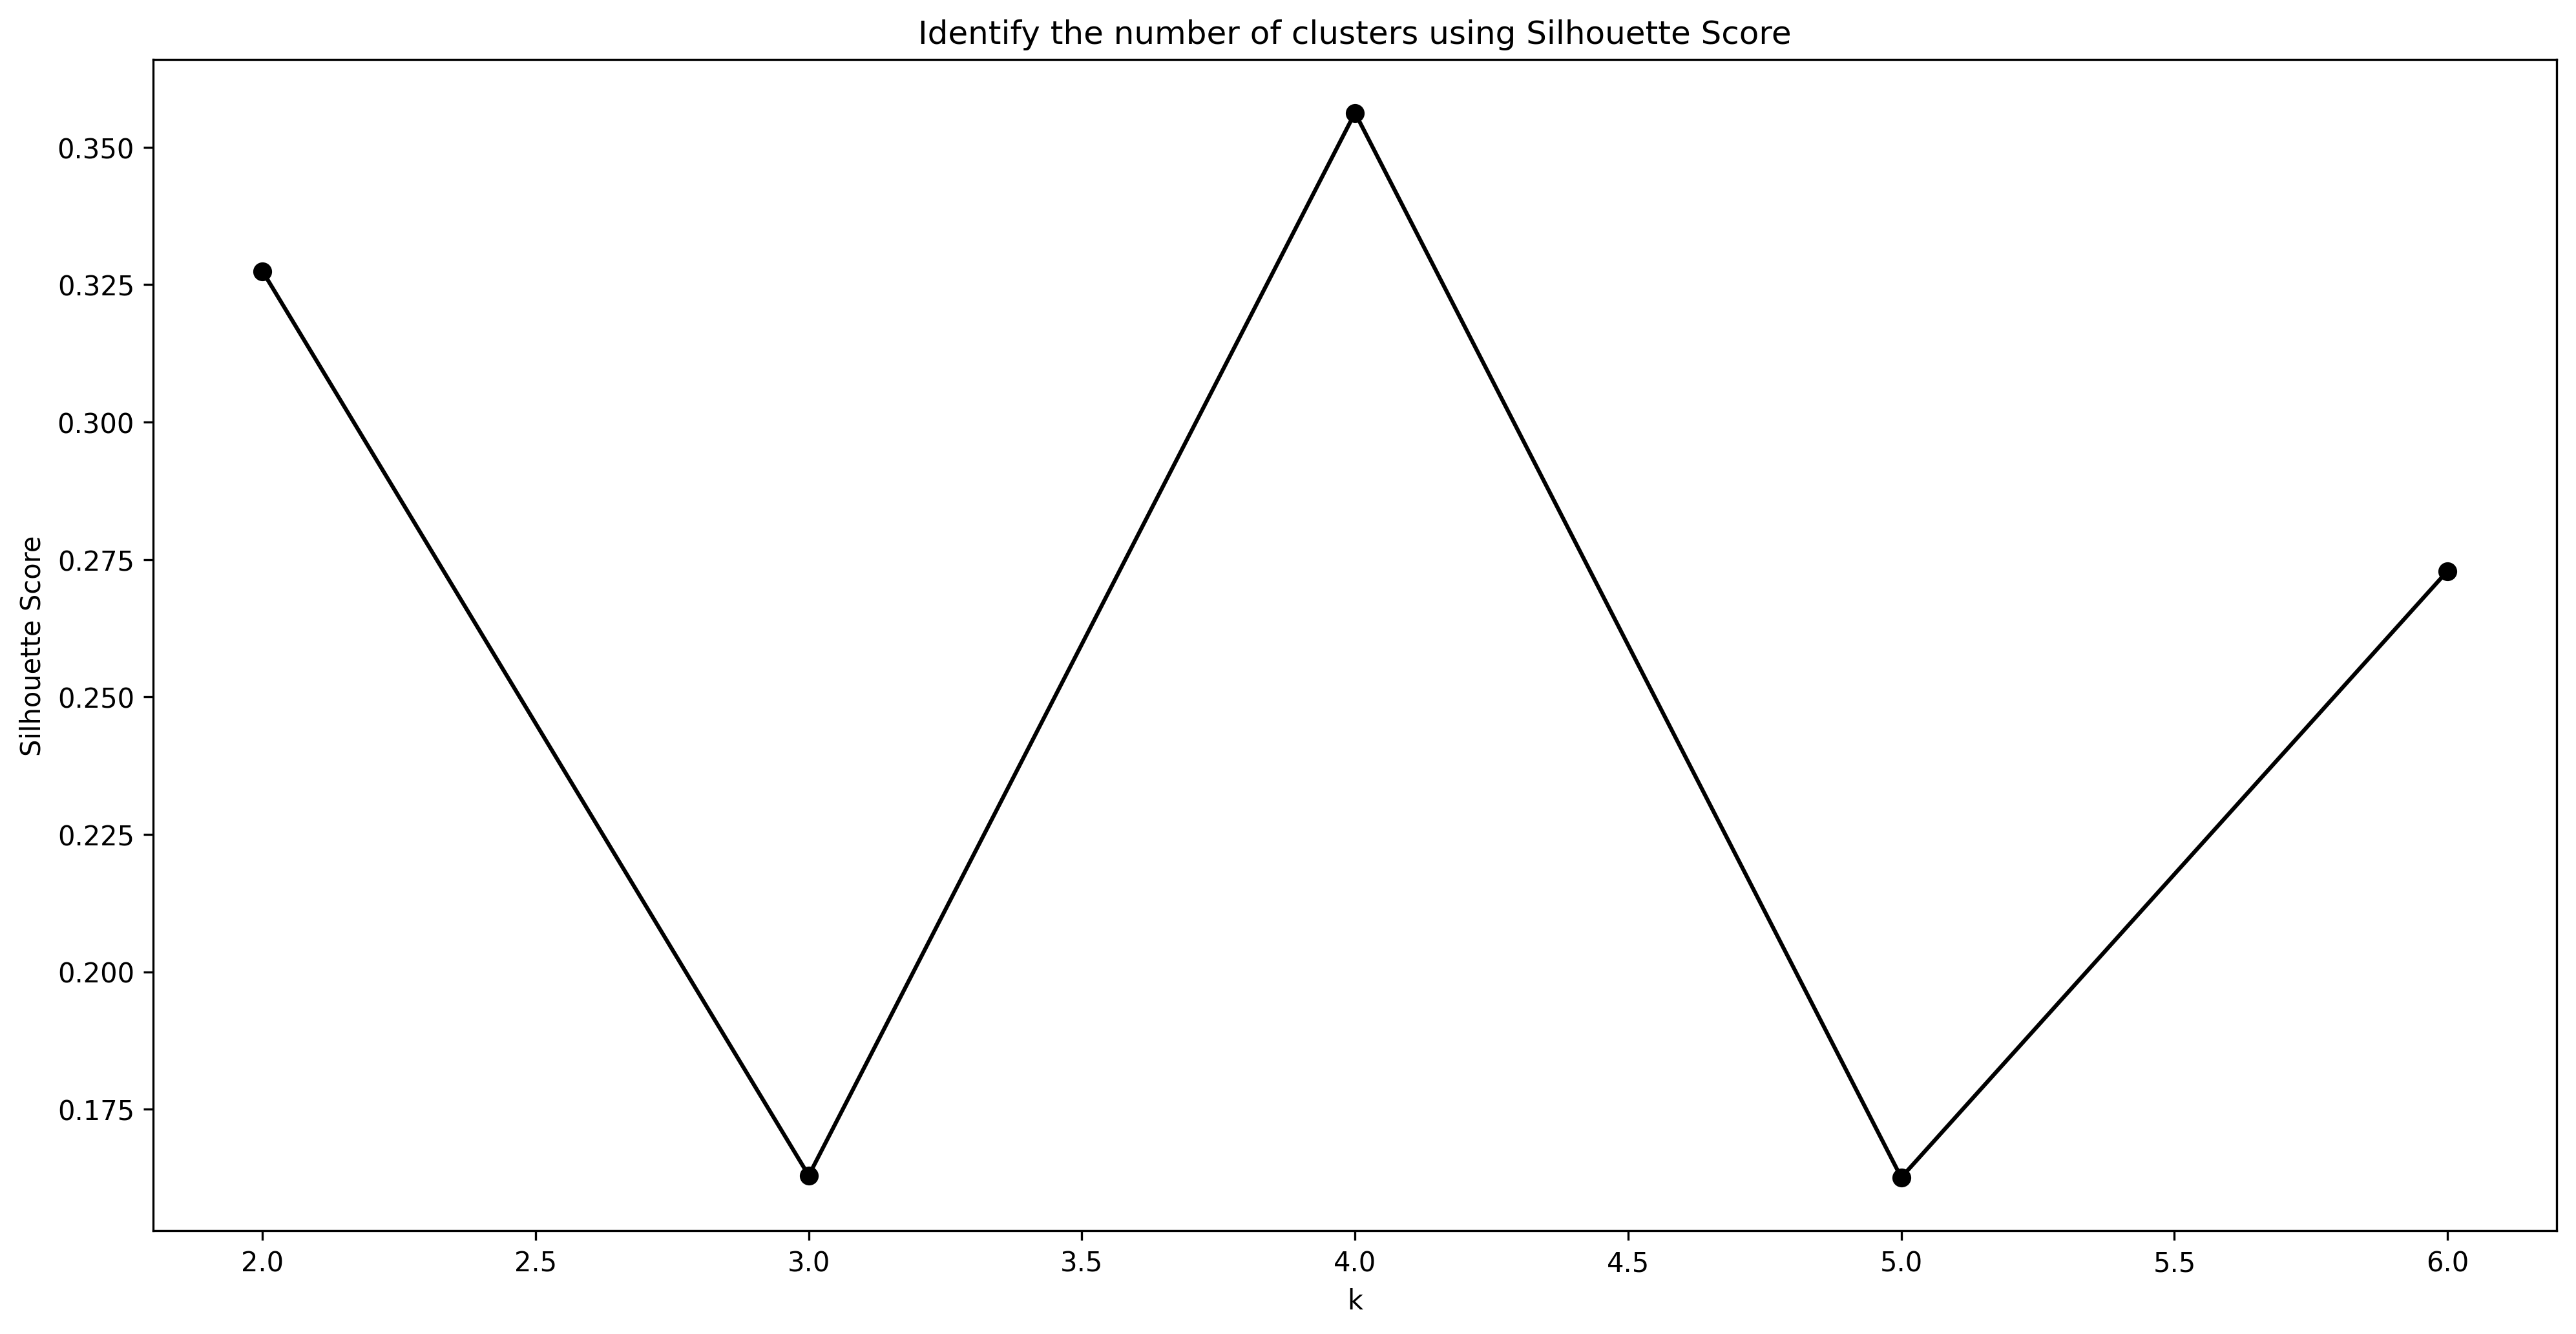

In [24]:
# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,7)

# Select data for clustering model
X = chicago_df_q[['Trip Start Hour', 'Trip Kilometers']]

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    # Fit the model
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(silhouette_score(X, labels, metric='euclidean', sample_size=1000, random_state=7))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()

In [25]:
#mms = StandardScaler()
#mms.fit(chicago_df)
#chicago_df_n = mms.transform(chicago_df_q)

distortions_chicago = []
K = range(1,10)

for k in K:
    kmeansModel = KMeans(n_clusters=k, init='k-means++', random_state=7)
    kmeansModel.fit(chicago_df_q)
    distortions_chicago.append(kmeansModel.inertia_)

fig = plt.figure(figsize=(6,6))
ax = sns.lineplot(x = K, y = distortions_chicago, color= 'C3')
ax.set_title('Elbow method showing the optimal k', fontsize=16, fontweight='bold',pad=20)
ax.set(xlabel ='K', ylabel='Inertia')
fig.tight_layout()

In [7]:
X = chicago_df_q[['Trip Start Hour', 'Trip Kilometers']]
EM = GaussianMixture(n_components=4, random_state=7)
EM.fit(X)
cluster = EM.predict(X)
#print('SILHOUETTE: ', silhouette_score(X, cluster))
X['cluster'] = cluster
(ggplot(X, aes(y = 'Trip Start Hour', x = 'Trip Kilometers', color = 'cluster'))+geom_point())

(unique, counts) = np.unique(cluster, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print (frequencies)

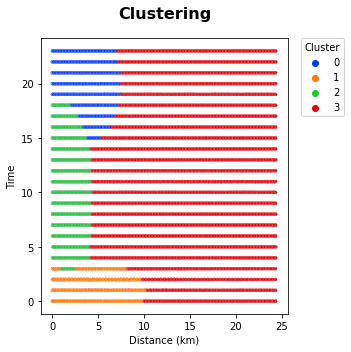

In [17]:
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(data=X, x="Trip Kilometers",y='Trip Start Hour', hue='cluster', s=10, alpha=0.1, palette='bright')
ax.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0., title='Cluster')
ax.set_title('Clustering', fontsize=16, fontweight='bold',pad=20)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Time')
fig.tight_layout()



TypeError: '(slice(None, None, None), 0)' is an invalid key

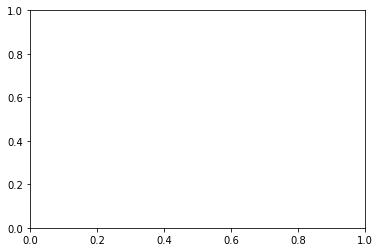

In [66]:
plot_gmm(EM, X)

In [65]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [63]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))